In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import transforms

import torch.nn as nn       # torch.nn module, contains classes and functions to help build neural networks

import torch.optim as optim # provides various optimization algorithms, such as SGD (Stochastic Gradient Descent), Adam, etc
from torch.utils.data import DataLoader, TensorDataset # Dataloader - helps to load data, TensorDataset - allows to access data points as pairs(i/p, target)

from scipy.special import softmax
from sklearn.metrics import confusion_matrix, accuracy_score


# Downloading the MNIST digit datasets

In [2]:
# Ensuring one-hot format
def one_hot_encoder(x):
  temp_array = np.zeros(10, dtype=float) # numpy arrays of zeros with length 10, 0 through 9
  temp_array[x] = 1 # element at index x in the temp array set to 1
  return temp_array

# To normalize the input
def transform(x):
  return np.array(x)/255.0

In [3]:
train_data = datasets.MNIST(root='./data', train = True , download=True, transform=transform, target_transform = one_hot_encoder)
test_data = datasets.MNIST(root='./data', train = False ,download=True, transform=transform, target_transform = one_hot_encoder)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4518298.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 56805.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1245651.84it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4021644.24it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
len(train_data)

60000

In [5]:
len(test_data)

10000

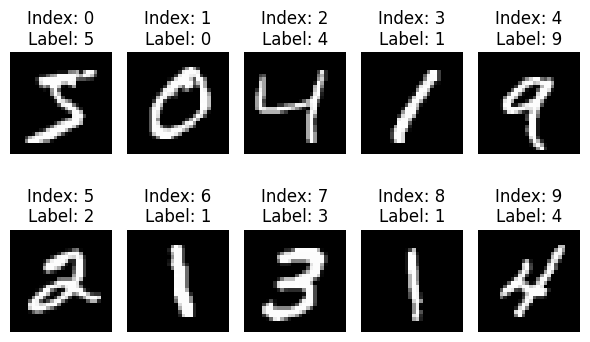

In [6]:
# Visualizing the data
fig, axes = plt.subplots(2, 5, figsize=(6, 4))  # 2 rows, 5 columns

for i in range(10):          # Loop through the first 10 images
  ax = axes[i // 5, i % 5]  # Determine the position of the subplot (row, column)

  ax.imshow(train_data.data[i], cmap='gray') # Display each image in grayscale
  ax.set_title(f"Index: {i}\nLabel: {train_data.targets[i].item()}")
  ax.axis('off')

plt.tight_layout() # Adjust layout to prevent overlap of titles
plt.show()

In [7]:
# organize the data in batches
# want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [8]:
len(train_dataloader)

938

In [9]:
len(test_dataloader)

157

# Code from scratch

In [10]:
input_layer = train_data.data[i].flatten().shape[0]
hidden1_layer = 500
hidden2_layer = 250
hidden3_layer = 100
out_layer = train_data.train_labels.unique().shape[0]

layers_dims = [input_layer, hidden1_layer, hidden2_layer, hidden3_layer, out_layer]


def initialize_parameters(layer_dimensions, initial):
  parameters = {}
  num_layers = len(layer_dimensions) # number of layers in the network

  for layer in range(1, num_layers):
    if initial == "glorot":  # glorot intitalization
      M = np.sqrt(6*(1/(layer_dimensions[layer]+layer_dimensions[layer-1])))
      parameters['W' + str(layer)] = np.random.uniform(low = -M, high = M, size = (layer_dimensions[layer], layer_dimensions[layer-1]))
      parameters['b' + str(layer)] = np.zeros((layer_dimensions[layer], 1))

    elif initial == "random": # Random Initialization
      parameters['W' + str(layer)] = np.random.randn(layer_dimensions[layer], layer_dimensions[layer-1]) / np.sqrt(layer_dimensions[layer-1])
      parameters['b' + str(layer)] = np.zeros((layer_dimensions[layer], 1))

    else: # Zero Initialization
      parameters['W' + str(layer)] = np.zeros((layer_dimensions[layer], layer_dimensions[layer-1]))
      parameters['b' + str(layer)] = np.zeros((layer_dimensions[layer], 1))

    assert(parameters['W' + str(layer)].shape == (layer_dimensions[layer], layer_dimensions[layer-1]))
    assert(parameters['b' + str(layer)].shape == (layer_dimensions[layer], 1))

  return parameters

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


#  Activation Function

In [11]:
# Sigmoid activation function
def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

# Softmax function for output probabilities
# def softmax(x):
#     exps = np.exp(x - np.max(x, axis=0))
#     return exps / exps.sum(axis=0)

# def softmax(Z, axis=None):
#   exp_Z = np.exp(Z - np.max(Z))  # Subtract max for numerical stability
#   return exp_Z / np.sum(exp_Z, axis=axis, keepdims=True)

# ReLu
def relu(x):
  return np.maximum(x, 0)

# tanh activation function
def tanh(x):
  return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))


# Forward Propagation

In [12]:
def forward_propagation(input_data, parameters, activation_function):
    forward_propagation = {}
    num_layers = int(len(parameters) / 2)  # Total number of layers (excluding input)

    forward_propagation['Z1'] = np.dot(parameters['W1'], input_data) + parameters['b1'] # Linear transformation for the first layer

    # Loop through layers 2 to (num_layers - 1) (hidden layers)
    for layer in range(2, num_layers):
        forward_propagation['A' + str(layer - 1)] = activation_function(forward_propagation['Z' + str(layer - 1)]) # Activation from the previous layer

        # Linear transformation for the current layer
        forward_propagation['Z' + str(layer)] = np.dot(parameters['W' + str(layer)], forward_propagation['A' + str(layer - 1)]) + parameters['b' + str(layer)]

    # final layer's activation using softmax
    forward_propagation['A' + str(num_layers - 1)] = activation_function(forward_propagation['Z' + str(num_layers - 1)])
    forward_propagation['Z' + str(num_layers)] = np.dot(parameters['W' + str(num_layers)], forward_propagation['A' + str(num_layers - 1)]) + parameters['b' + str(num_layers)]

    forward_propagation['A' + str(num_layers)] = softmax(forward_propagation['Z' + str(num_layers)], axis=0) # Output layer: apply softmax
    cache = (forward_propagation, parameters) # Store forward pass results and parameters for backpropagation

    return forward_propagation['A' + str(num_layers)], cache



# Backpropagation

In [14]:
def back_propagation(input, labels, cache):

  num_examples = input.shape[1]  # Number of examples in the batch (m)
  forward_propagation, parameters = cache # Extract activations and parameters from cache
  num_layers = len(parameters) // 2  # Number of layers (assuming W1, b1, ..., WL, bL)

  # Initialize a dictionary to store gradients
  grads = {}
  grads['dZ' + str(num_layers)] = forward_propagation['A' + str(num_layers)] - labels

  # Backpropagate through all hidden layers (in reverse order)
  for layer in range(num_layers-1, 0, -1):

    # Compute gradients for weights and biases
    grads['dW' + str(layer+1)] = (1. / num_examples) * np.dot(grads['dZ' + str(layer+1)], forward_propagation['A'+ str(layer)].T)
    grads['db' + str(layer+1)] = (1. / num_examples) * np.sum(grads['dZ' + str(layer+1)], axis=1, keepdims=True)
    grads['dA'+ str(layer)] = np.dot(parameters['W'+ str(layer+1)].T, grads['dZ'+ str(layer+1)])
    grads['dZ' + str(layer)] = grads['dA' + str(layer)] * forward_propagation['A' + str(layer)] * (1-forward_propagation['A' + str(layer)])

  grads['dW1'] = 1./num_examples * np.dot(grads['dZ1'], input.T)
  grads['db1'] = 1./num_examples * np.sum(grads['dZ1'], axis=1, keepdims = True)

  return grads


# Update parameters

In [15]:
def update_parameters(parameters, grads, learning_rate, lambd=0):
  num_layers = len(parameters) // 2  # Number of layers in the network

  for layer in range(num_layers):
    # Update weights with regularization (if lambd > 0)
    parameters["W" + str(layer + 1)] -= (learning_rate * (grads["dW" + str(layer + 1)] + lambd * parameters["W" + str(layer + 1)]))

    # Update biases (biases are not regularized)
    parameters["b" + str(layer + 1)] -= (learning_rate * grads["db" + str(layer + 1)])

  return parameters


# Cost Funtion

In [16]:
def cross_entropy_cost(predictions, labels):
  num_examples = labels.shape[1]

  # Compute cross-entropy loss
  loss_per_example = np.multiply(-np.log(predictions), labels) + np.multiply(-np.log(1 - predictions), 1 - labels)
  average_cost = 1. / num_examples * np.sum(loss_per_example)

  return average_cost


In [22]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Accuracy and Confusion matrix

In [23]:
def accuracy(parameter, test_data, function):
  size = test_data.data.shape[0] # total number of test samples
  img_size = test_data.data.shape[1] * test_data.data.shape[2]

  test_dataloader = next(iter(DataLoader(test_data, batch_size=size, shuffle=True))) # Create a DataLoader for the test data
  X = np.swapaxes(np.array(test_dataloader[0]),0,2).reshape(img_size, size) # Reshape the test images

  pred = np.swapaxes(forward_propagation(X, parameter, function)[0], 0, 1) # forward propagation to get predictions
  Y = np.array(test_dataloader[1]) # true labels

  # Compute accuracy by comparing the predicted and true labels
  accuracy = accuracy_score(np.argmax(Y, axis=1), np.argmax(pred, axis=1))
  return accuracy

In [24]:
def confusion_mat(parameter, test_data, function):
  size = test_data.data.shape[0] # total number of test samples
  img_size = test_data.data.shape[1] * test_data.data.shape[2]

  test_dataloader = next(iter(DataLoader(test_data, batch_size=size, shuffle=True)))
  X = np.swapaxes(np.array(test_dataloader[0]),0,2).reshape(img_size, size)

  pred = np.swapaxes(forward_propagation(X, parameter, function)[0], 0, 1)
  Y = np.array(test_dataloader[1])

  confu_matrix = confusion_matrix(np.argmax(Y, axis=1), np.argmax(pred, axis=1))
  return confu_matrix


# Training the model

In [26]:
def model(train_dataloader, test_data, batch_size=64, learning_rate=0.01, epoch=10, print_cost=True, lambd=0, initial="random", function=sigmoid):
    grads = {}
    train_costs = []  # To store training costs
    test_costs = []   # To store test costs
    layers_dims = [input_layer, hidden1_layer, hidden2_layer, hidden3_layer, out_layer]
    parameters = initialize_parameters(layers_dims, initial)
    count = 0

    for i in range(epoch):
        for (batch_idx, batch) in enumerate(train_dataloader):
            batch_x, batch_y = batch
            X = np.swapaxes(np.array(batch_x), 0, 2).reshape(batch_x.shape[1]*batch_x.shape[2], batch_x.shape[0])
            Y = np.swapaxes(np.array(batch_y), 0, 1)

            # Forward propagation
            a3, cache = forward_propagation(X, parameters, function)
            train_cost = cross_entropy_cost(a3, Y)

            # Backward propagation and parameter update
            grads = back_propagation(X, Y, cache)
            parameters = update_parameters(parameters, grads, learning_rate, lambd=lambd)

            if batch_idx % 200 == 0:
                train_costs.append(train_cost)

                # Calculate test loss at every 200th batch
                test_dataloader = next(iter(DataLoader(test_data, batch_size=batch_size, shuffle=True)))
                test_x = np.swapaxes(np.array(test_dataloader[0]), 0, 2).reshape(test_dataloader[0].shape[1]*test_dataloader[0].shape[2], test_dataloader[0].shape[0])
                test_y = np.swapaxes(np.array(test_dataloader[1]), 0, 1)
                test_a3, _ = forward_propagation(test_x, parameters, function)
                test_cost = cross_entropy_cost(test_a3, test_y)
                test_costs.append(test_cost)

            if print_cost and batch_idx % 200 == 0:
                print(f"Cost after epoch {i}, iteration {batch_idx}: Train Cost: {train_cost}, Test Cost: {test_cost}")

    return parameters, train_costs, test_costs


In [28]:
def plotting(parameters, test_data, train_data, function):
    # test and train accuracy, passing the 'function' parameter
    test_acc = accuracy(parameters[0], test_data, function)
    train_acc = accuracy(parameters[0], train_data, function)

    conf_matrix = confusion_mat(parameters[0], test_data, function) # confusion matrix for the test data

    fig, (ax, bx) = plt.subplots(1, 2, figsize=(20, 8)) # two subplots: for the confusion matrix & for the loss curves

    # confusion matrix
    ax.matshow(conf_matrix, cmap='viridis', alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    ax.set_xlabel('Predicted Label', fontsize=18)
    ax.set_ylabel('True Label', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=18)

    # cost curve over iterations (training and test)
    bx.plot(range(0, len(parameters[1])), parameters[1], label='Train Loss', color='b')
    bx.plot(range(0, len(parameters[2])), parameters[2], label='Test Loss', color='r')

    bx.set_xlabel('Iteration (x 200)', fontsize=18)
    bx.set_ylabel('Loss', fontsize=18)
    bx.set_title('Training and Test Loss Over Iterations', fontsize=18)
    bx.legend()

    # Combine test and train accuracy in a label for the plot
    label = f"Test acc. = {test_acc * 100:.2f}%, Train acc. = {train_acc * 100:.2f}%"
    plt.suptitle(label, fontsize=20)

    plt.tight_layout()
    plt.show()


Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=zero
Cost after epoch 0, iteration 0: Train Cost: 3.250829733914482, Test Cost: 3.2501445954240697
Cost after epoch 0, iteration 200: Train Cost: 3.2565329875540816, Test Cost: 3.2319978981871307
Cost after epoch 0, iteration 400: Train Cost: 3.25339618727332, Test Cost: 3.255656229483162
Cost after epoch 0, iteration 600: Train Cost: 3.2502085364189286, Test Cost: 3.260764734994694
Cost after epoch 0, iteration 800: Train Cost: 3.249378139533564, Test Cost: 3.261425518027011
Cost after epoch 1, iteration 0: Train Cost: 3.2587339809720453, Test Cost: 3.2438677564201277
Cost after epoch 1, iteration 200: Train Cost: 3.261504600220028, Test Cost: 3.2503987476564458
Cost after epoch 1, iteration 400: Train Cost: 3.2506611852155576, Test Cost: 3.255694773104604
Cost after epoch 1, iteration 600: Train Cost: 3.2492749719657006, Test Cost: 3.2589763293863605
Cost after epoch 1, iteration 800: Train Cost: 3.240837990512092

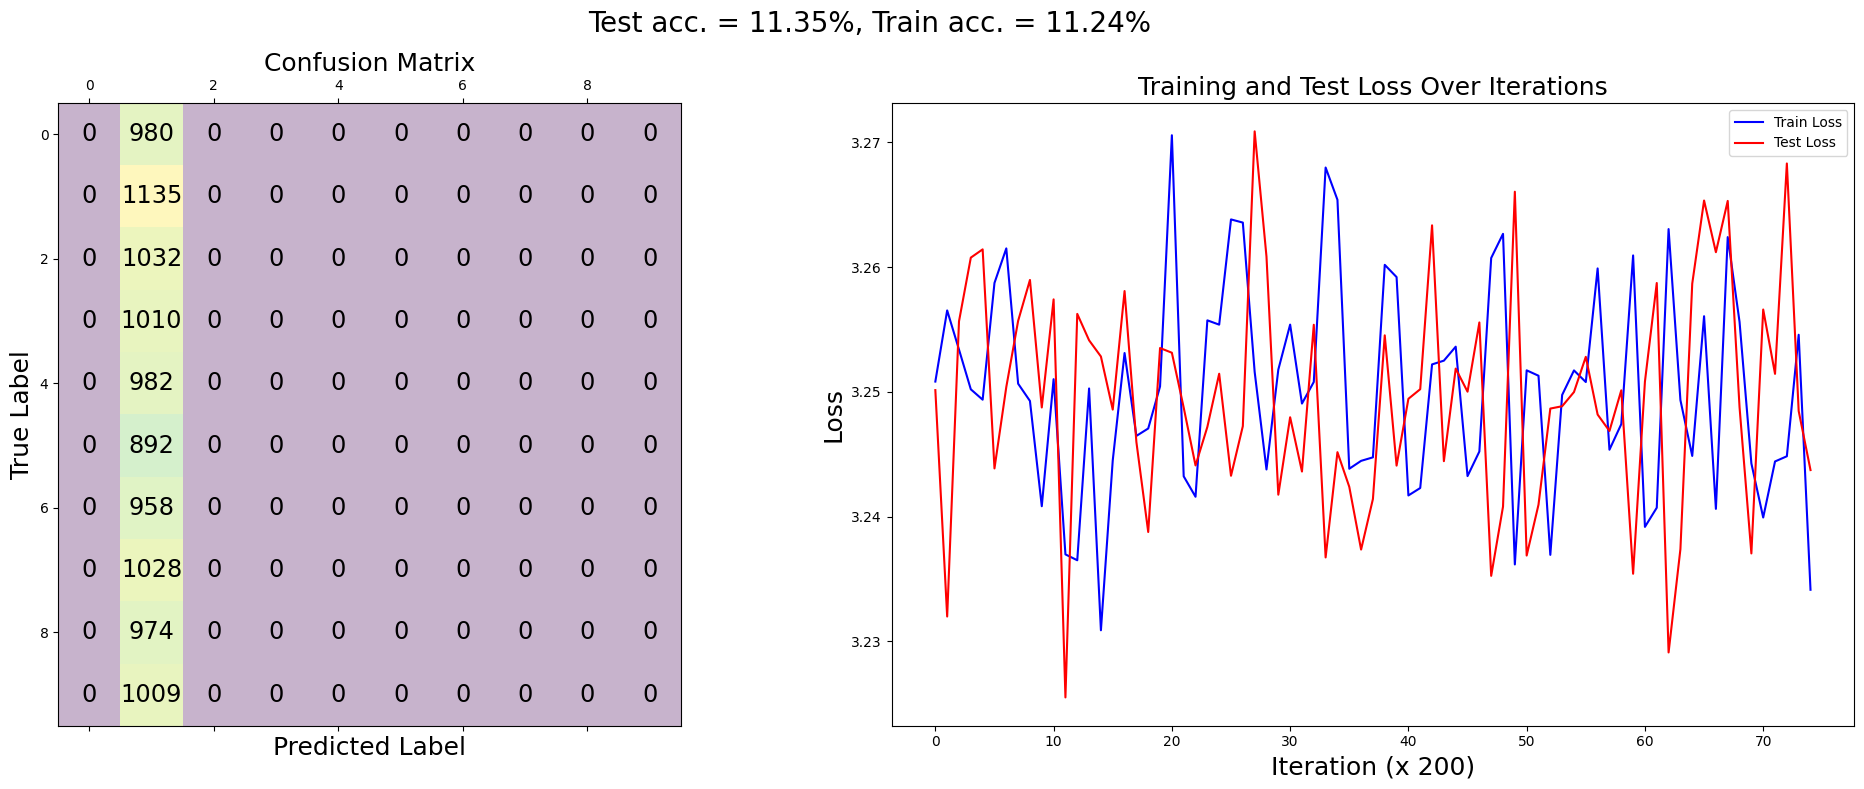

In [31]:
# Dictionary to store learned parameters for different models
learned_parameters = {}

learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "zero"
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

#  model name (key) based on training parameters
model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)

# Train the model and store the learned parameters
learned_parameters[model_name] = model(train_dataloader, test_data, batch_size=batch_size, learning_rate=learning_rate, epoch=epoch, print_cost=True, lambd=lambd, initial=initial)

# Find the model with 'zero' initialization dynamically
i = [key for key in learned_parameters.keys() if "Initilization=zero" in key][0]

# Plotting the losses and confusion matrix
plotting(learned_parameters[i], test_data, train_data, sigmoid)


In [ ]:
print("Available model keys:", learned_parameters.keys())

Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=random
Cost after epoch 0, iteration 0: Train Cost: 3.519360144013942, Test Cost: 3.421410931096408
Cost after epoch 0, iteration 200: Train Cost: 3.2592092895664875, Test Cost: 3.2535988834490084
Cost after epoch 0, iteration 400: Train Cost: 3.2743739861694334, Test Cost: 3.2414804591279838
Cost after epoch 0, iteration 600: Train Cost: 3.240629678421011, Test Cost: 3.2448357055564876
Cost after epoch 0, iteration 800: Train Cost: 3.247208632769028, Test Cost: 3.2466694616005864
Cost after epoch 1, iteration 0: Train Cost: 3.251322893857357, Test Cost: 3.242677470297336
Cost after epoch 1, iteration 200: Train Cost: 3.248305123739125, Test Cost: 3.23560716561706
Cost after epoch 1, iteration 400: Train Cost: 3.2402493965780113, Test Cost: 3.2294770894299556
Cost after epoch 1, iteration 600: Train Cost: 3.2403541162958276, Test Cost: 3.2349667942985203
Cost after epoch 1, iteration 800: Train Cost: 3.2649508866171

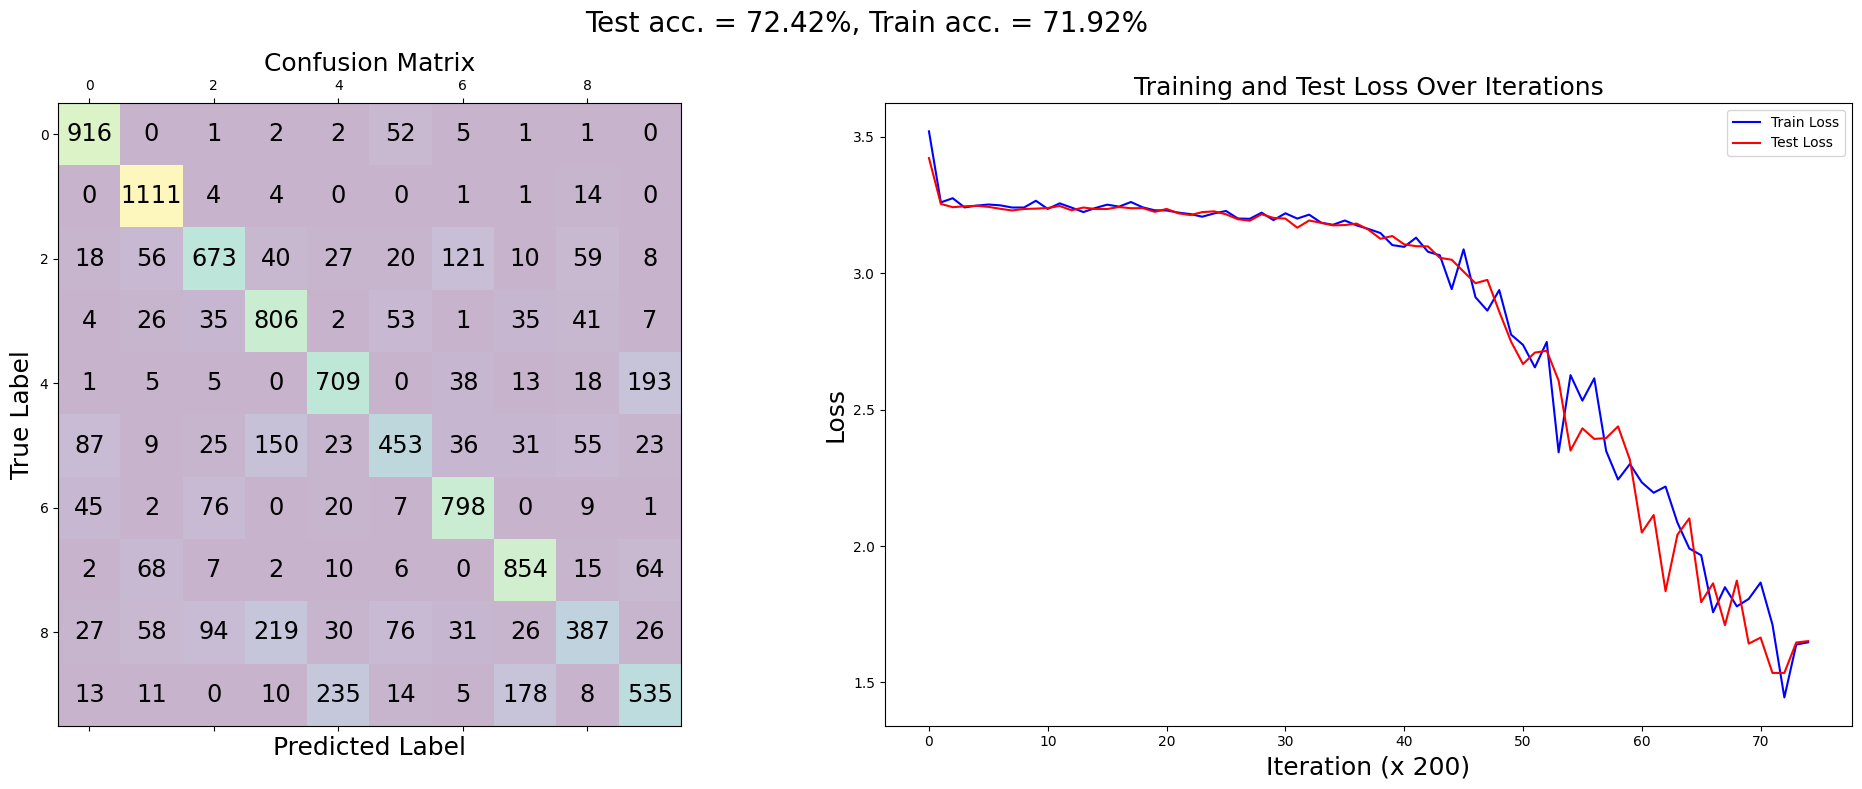

In [32]:
# Dictionary to store learned parameters for different models
learned_parameters = {}

learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "random"
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a model name (key) based on training parameters
model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)

# Train the model and store the learned parameters
learned_parameters[model_name] = model(train_dataloader, test_data, batch_size=batch_size, learning_rate=learning_rate, epoch=epoch, print_cost=True, lambd=lambd, initial=initial)

# Find the model with 'zero' initialization dynamically
i = [key for key in learned_parameters.keys() if "Initilization=random" in key][0]

# Plotting the losses and confusion matrix
plotting(learned_parameters[i], test_data, train_data, sigmoid)


Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=glorot
Cost after epoch 0, iteration 0: Train Cost: 3.364798570254992, Test Cost: 3.4234719927068054
Cost after epoch 0, iteration 200: Train Cost: 3.243369220322021, Test Cost: 3.248316170407343
Cost after epoch 0, iteration 400: Train Cost: 3.239952774484645, Test Cost: 3.2231276027637827
Cost after epoch 0, iteration 600: Train Cost: 3.260996398545833, Test Cost: 3.2348077026819415
Cost after epoch 0, iteration 800: Train Cost: 3.2458382898675375, Test Cost: 3.22923214283201
Cost after epoch 1, iteration 0: Train Cost: 3.236380140797255, Test Cost: 3.235467781342831
Cost after epoch 1, iteration 200: Train Cost: 3.2324376071011782, Test Cost: 3.2294144020777233
Cost after epoch 1, iteration 400: Train Cost: 3.226601522035077, Test Cost: 3.2403583921036274
Cost after epoch 1, iteration 600: Train Cost: 3.2205031569197335, Test Cost: 3.2279088112222136
Cost after epoch 1, iteration 800: Train Cost: 3.22386997551782

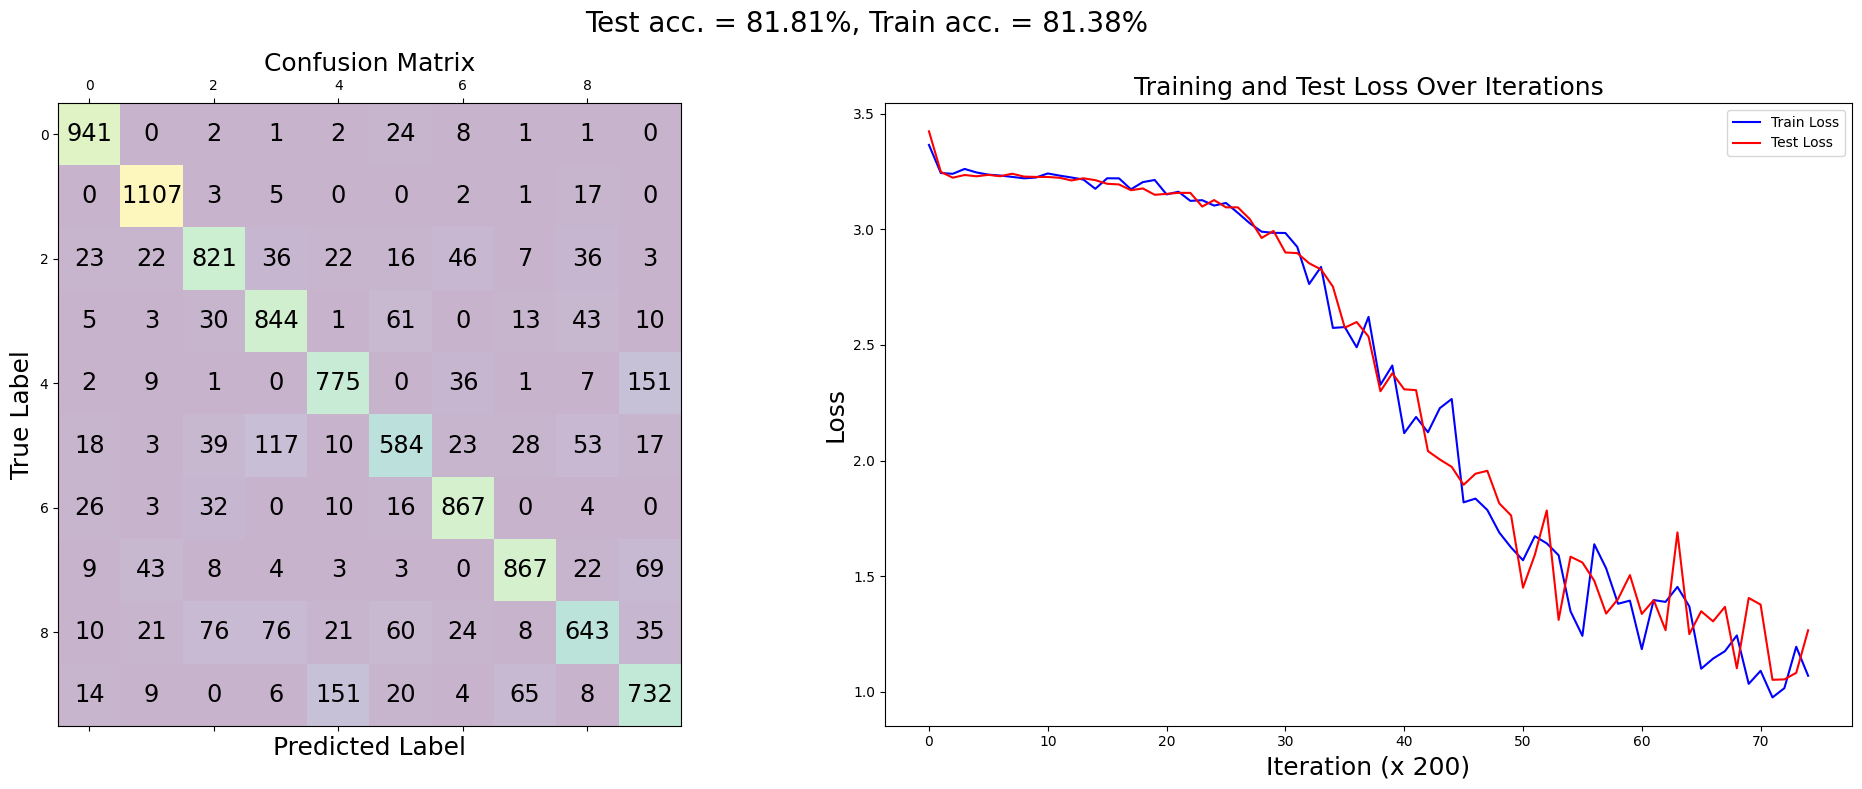

In [33]:
# Dictionary to store learned parameters for different models
learned_parameters = {}

learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "glorot"
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a model name (key) based on training parameters
model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)

# Train the model and store the learned parameters
learned_parameters[model_name] = model(train_dataloader, test_data, batch_size=batch_size, learning_rate=learning_rate, epoch=epoch, print_cost=True, lambd=lambd, initial=initial)

# Find the model with 'zero' initialization dynamically
i = [key for key in learned_parameters.keys() if "Initilization=glorot" in key][0]

# Plotting the losses and confusion matrix
plotting(learned_parameters[i], test_data, train_data, sigmoid)


Model Key: Epoch=15,alpha=0.3,Regularization=0,Batch=64,Initilization=glorot
Cost after epoch 0, iteration 0: Train Cost: 3.4279112610278846, Test Cost: 3.398787321284636
Cost after epoch 0, iteration 200: Train Cost: 3.043075569907403, Test Cost: 3.0866634615144695
Cost after epoch 0, iteration 400: Train Cost: 1.7837047317592867, Test Cost: 1.676738149735876
Cost after epoch 0, iteration 600: Train Cost: 0.8526466934907384, Test Cost: 0.9843355101585898
Cost after epoch 0, iteration 800: Train Cost: 0.8478836011458577, Test Cost: 0.9236939482056857
Cost after epoch 1, iteration 0: Train Cost: 1.0859324942424613, Test Cost: 0.8386687630666643
Cost after epoch 1, iteration 200: Train Cost: 0.9667986712697354, Test Cost: 0.658991474686235
Cost after epoch 1, iteration 400: Train Cost: 0.7646010544192154, Test Cost: 0.586674486919407
Cost after epoch 1, iteration 600: Train Cost: 0.4107641543362994, Test Cost: 0.6610818875916682
Cost after epoch 1, iteration 800: Train Cost: 0.5678795383

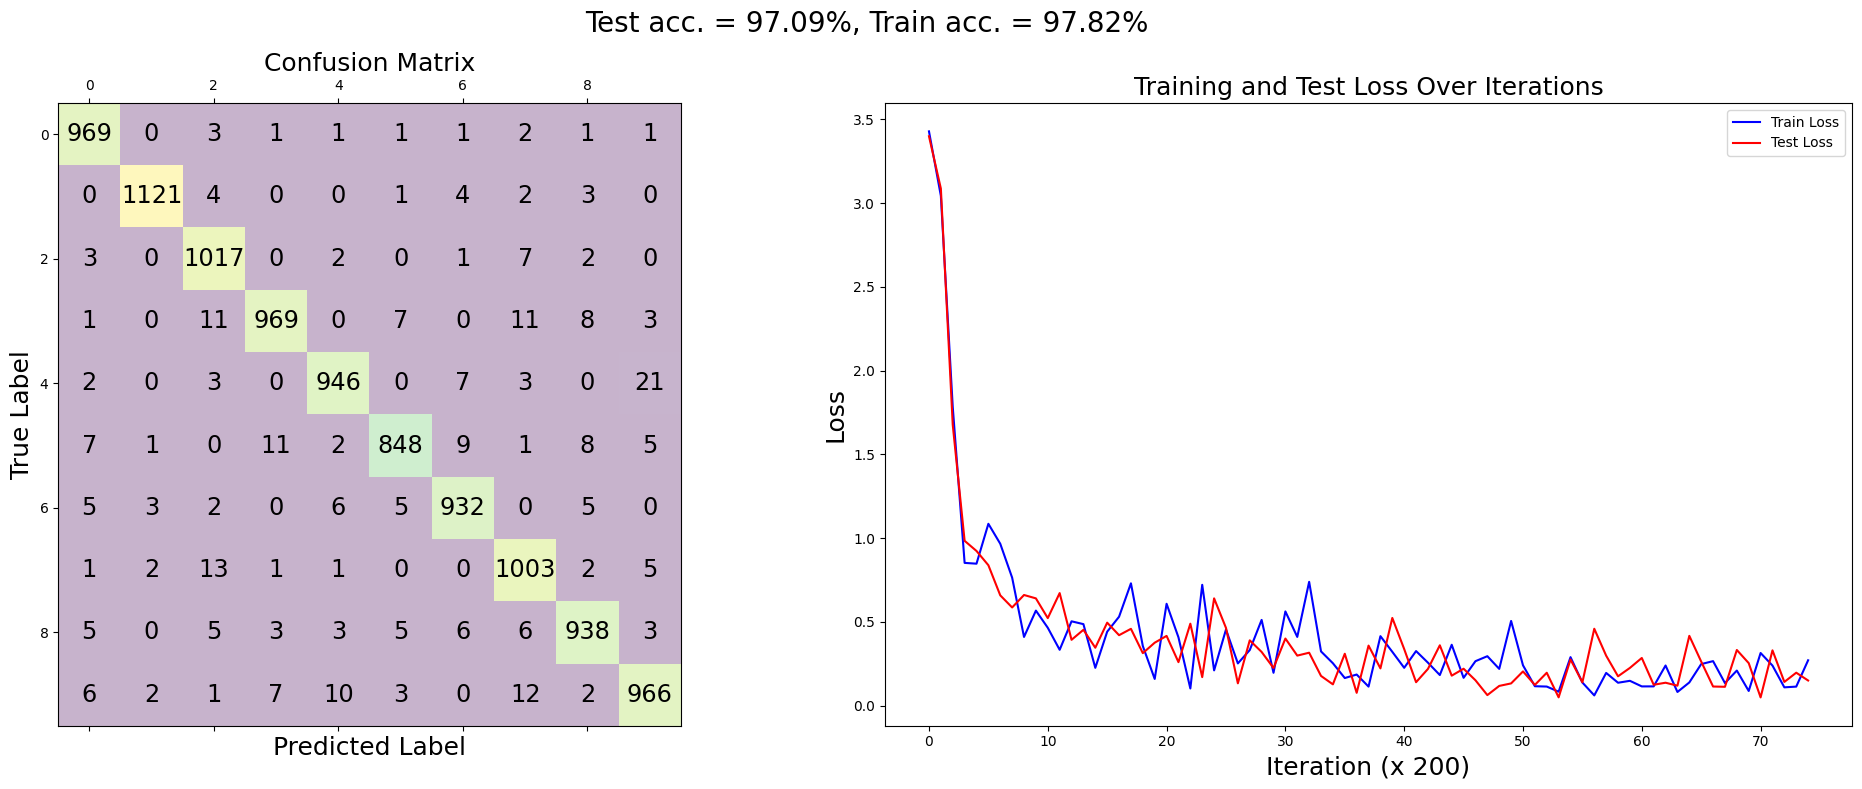

In [34]:
# Dictionary to store learned parameters for different models
learned_parameters = {}

learning_rate = 0.3
lambd = 0
epoch = 15
batch_size = 64
initial = "glorot"
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a model name (key) based on training parameters
model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)

# Train the model and store the learned parameters
learned_parameters[model_name] = model(train_dataloader, test_data, batch_size=batch_size, learning_rate=learning_rate, epoch=epoch, print_cost=True, lambd=lambd, initial=initial)

# Find the model with 'zero' initialization dynamically
i = [key for key in learned_parameters.keys() if "Initilization=glorot" in key][0]

# Plotting the losses and confusion matrix
plotting(learned_parameters[i], test_data, train_data, sigmoid)
